# Pululagua Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/pululagua/pulu_real_data.csv"

raw_df, grid = io.import_pululagua(filename)

grid.to_csv("data/pululagua/pulu_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample,Easting,Northing,Altitude,Thickness,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)",...,"[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",total,Md(phi),Sorting,SkG,radius
5,PL12,4105,1558,2358,16.5,165,0,0,888.3,"1,203.1",...,19.92,7.91,1.67,0.32,0.03,100,-1.67,2.68,-0.02,"4,390.72"
24,PL40,1032,-4703,2599,28,280,833.76,"1,492.62","1,744.88","1,159.76",...,10.37,3.52,0.85,0.18,0.01,100,-4.2,2.96,0.23,"4,814.9"
25,PL41,1018,-4731,2615,35,350,"1,481.98",564.95,"2,152.07","1,155.8",...,12.18,3.88,0.78,0.15,0.01,100,-4.31,2.73,0.09,"4,839.29"
4,PL11,5068,-1933,2738,17,170,0,0,524.55,"1,151.43",...,9.18,3.86,0.83,0.16,0.02,99.9999,-1.63,2.45,0.01,"5,424.12"
6,PL13,5463,3958,1934,14,140,0,0,286.61,850.53,...,30.46,14.48,3.34,0.66,0.04,100,-0.5,2.42,-0.2,"6,746.12"


## Preprossessing Steps

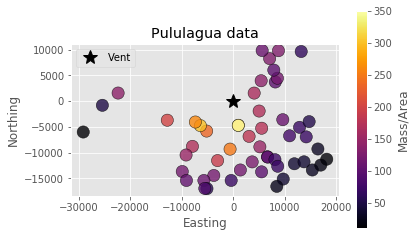

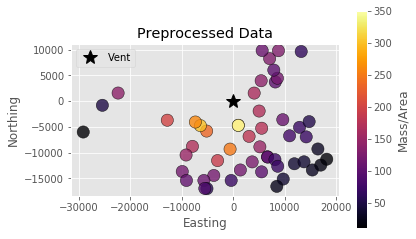

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("pululagua/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("pululagua/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
t2_df, _, _, _ = io.read_tephra2("data/pululagua/pulu_out.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)",...,"[3,4)","[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",radius,Residual
0,4105,1558,0,159.345,0.0696127,0.363263,1.41018,4.11607,9.1122,15.4036,...,1.57705,0.0499285,0.000736347,7.41802e-06,5.50103e-08,2.55349e-10,9.14655e-13,2.54016e-15,"4,390.72",0.965727
1,1032,-4703,0,180.987,0.0579496,0.311125,1.23449,3.66294,8.20795,13.998,...,2.03938,0.0468926,0.000654533,6.53995e-06,4.84418e-08,2.24821e-10,8.05287e-13,2.23642e-15,"4,814.9",0.646382
2,1018,-4731,0,180.914,0.057607,0.309804,1.23085,3.65573,8.19777,13.9882,...,2.04084,0.0469223,0.000654824,6.54263e-06,4.84614e-08,2.24912e-10,8.05612e-13,2.23733e-15,"4,839.29",0.516897
3,5068,-1933,0,152.806,0.0548726,0.307602,1.26261,3.84461,8.7833,15.1939,...,1.58051,0.0521082,0.000768194,7.73605e-06,5.73652e-08,2.66277e-10,9.53798e-13,2.64887e-15,"5,424.12",0.898859
4,5463,3958,0,134.37,0.0400833,0.248334,1.10428,3.57868,8.57208,15.3609,...,1.36057,0.0571784,0.000869457,8.79166e-06,6.52298e-08,3.02807e-10,1.08466e-12,3.0123e-15,"6,746.12",0.959786


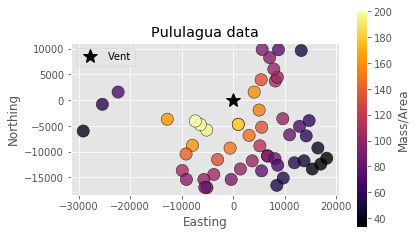

In [5]:
vis.plot_sample(t2_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()

In [6]:
config = io.read_tephra2_config("data/pululagua/pulu_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 19

config["MAX_GRAINSIZE"] = -8
config["MIN_GRAINSIZE"] = 11

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 0.1

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 2500.0,
 'PLUME_HEIGHT': 27000.0,
 'ALPHA': 1.1,
 'BETA': 1.1,
 'ERUPTION_MASS': 250000000000.0,
 'MAX_GRAINSIZE': -8,
 'MIN_GRAINSIZE': 11,
 'MEDIAN_GRAINSIZE': -0.2,
 'STD_GRAINSIZE': 2.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 92066.0,
 'FALL_TIME_THRESHOLD': 3600.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 19,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 0.1}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-7.5,"1,024","[-8,-7)",-8,9.93277e-05,-7
1,-6.5,"1,024","[-7,-6)",-7,0.00061611,-6
2,-5.5,"1,024","[-6,-5)",-6,0.00297627,-5
3,-4.5,"1,024","[-5,-4)",-5,0.0111973,-4
4,-3.5,"1,024","[-4,-3)",-4,0.0328079,-3
5,-2.5,"1,024","[-3,-2)",-3,0.0748637,-2
6,-1.5,"1,024","[-2,-1)",-2,0.133043,-1
7,-0.5,"1,024","[-1,0)",-1,0.184135,0
8,0.5,"1,233.5","[0,1)",0,0.198476,1
9,1.5,"1,443","[1,2)",1,0.166612,2


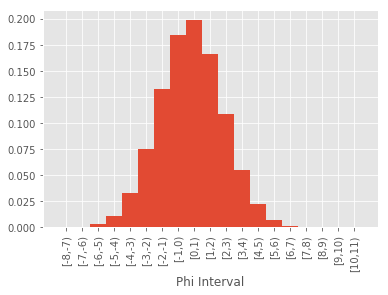

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 0,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

Forward Sim time: 0.06250 seconds
Dataframe Merge time: 0.06250 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.04688 seconds
Total time: 0.17188 seconds


,Northing,Easting,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)",...,"[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",MassArea,radius,Residual
0,1558,4105,0.0534419,0.279426,1.08655,3.17671,7.04596,11.9391,15.5367,15.3548,...,0.0497974,0.000630067,5.9401e-06,4.26281e-08,1.94426e-10,6.90354e-13,1.90886e-15,219.327,"4,390.72",1.32926
1,-4703,1032,0.0484693,0.260849,1.03713,3.08341,6.92412,11.8389,15.5072,15.3979,...,0.0504801,0.000638191,6.01531e-06,4.31662e-08,1.96879e-10,6.99064e-13,1.93294e-15,216.594,"4,814.9",0.773551
2,-4731,1018,0.0482061,0.259874,1.03462,3.079,6.91932,11.8371,15.5109,15.4059,...,0.0505384,0.000638962,6.02258e-06,4.32183e-08,1.97117e-10,6.99909e-13,1.93528e-15,216.333,"4,839.29",0.618094
3,-1933,5068,0.0423631,0.23815,0.979702,2.98916,6.84345,11.8682,15.7065,15.7127,...,0.0523607,0.000664193,6.26241e-06,4.49411e-08,2.04976e-10,7.27813e-13,2.01243e-15,208.039,"5,424.12",1.22376
4,3958,5463,0.0302957,0.188481,0.840588,2.73055,6.55544,11.7775,15.9957,16.3078,...,0.0567007,0.000722904,6.81802e-06,4.89296e-08,2.23168e-10,7.92409e-13,2.19104e-15,191.08,"6,746.12",1.36486


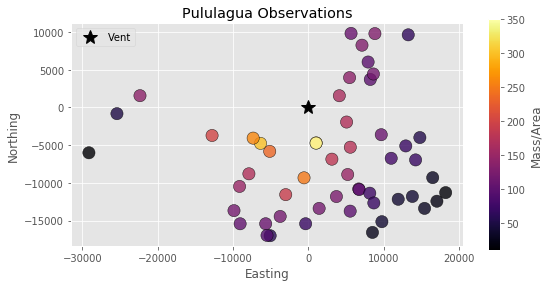

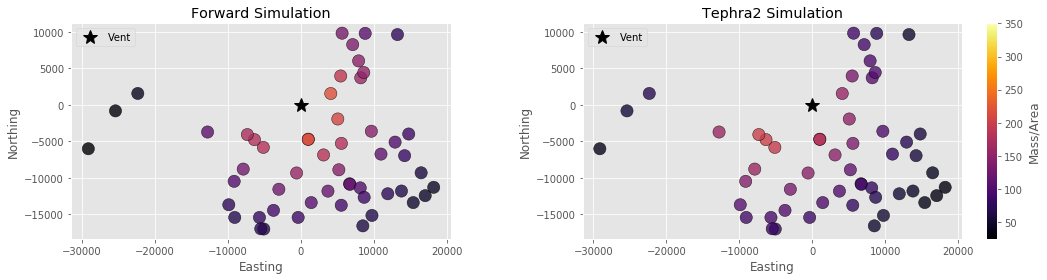

In [9]:
# fig, axs = plt.subplots(3,1, figsize=(
#         8,9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# vis.plot_sample(obs_df, vent=(0,0), log=False, 
#             title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
# vis.plot_sample(forward_df, vent=(0,0), log=False, 
#             title="Forward Simulation", cbar_label="Mass/Area", ax=axs[1])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
# #             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
# vis.plot_sample(t2_df, vent=(0,0), log=False, 
#             title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[2])

# plt.tight_layout()
# plt.show()

# fig, axs = plt.subplots(1,2, figsize=(
#         12,3), facecolor='w', edgecolor='k')
# axs = axs.ravel()


# vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
#             title="Forward Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
# #             title="Tephra2 Simulation (Const. Wind)", 
# #             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
# vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
#             title="Tephra2 Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])




# plt.tight_layout()
# plt.show()


bounds = (25, 350)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

vis.plot_sample(obs_df, vent=(0,0), log=False, bounds=None,
            title="Pululagua Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, bounds=bounds, show_cbar=False,
            title="Forward Simulation", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, bounds=bounds, show_cbar=True,
            title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[1])

plt.tight_layout()
plt.show()




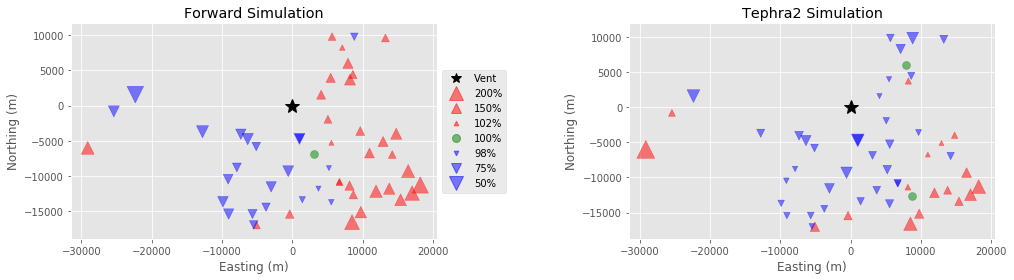

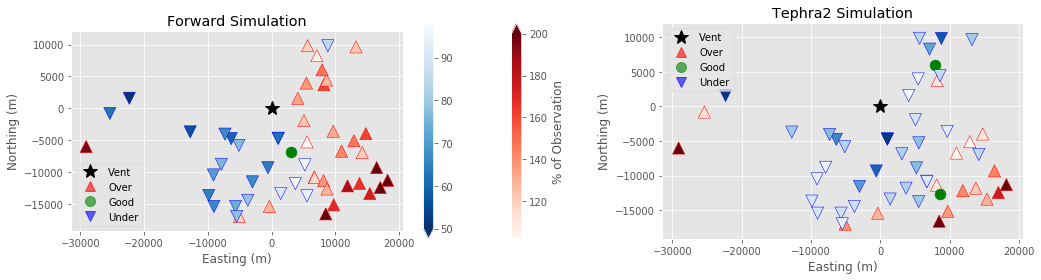

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", show_legend=True,
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", show_legend=False,
             plot_type = "size", ax=axs[1])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", 
            plot_type = "cmap", ax=axs[0], show_cbar = True)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)


plt.tight_layout()
plt.show()

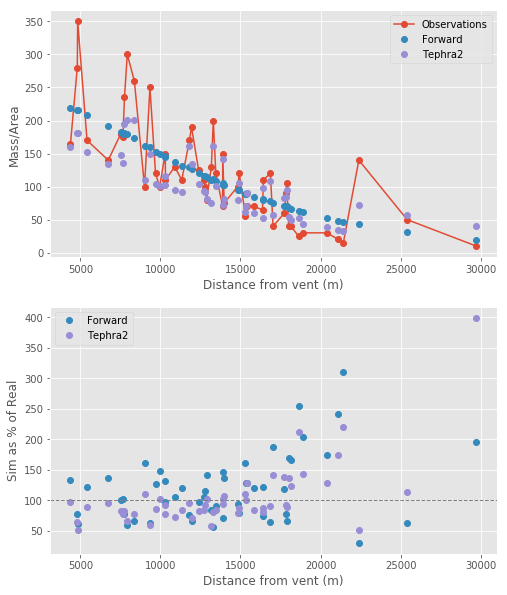

In [11]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C2o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Forward Simulation========
a* = -4.03900	b* = -2.19601            	h1* = 1.10793
a = 1.01762	b = 1.11125	h1 = 28749.99973
Success: True, Optimization terminated successfully.
Iterations: 117
SSE: 0.3574167648330073


,Height,Suspended Mass
0,"4,375",2.04056e+10
1,"6,250",2.04732e+10
2,"8,125",2.04213e+10
3,"10,000",2.03086e+10
4,"11,875",2.0151e+10
5,"13,750",1.99527e+10
6,"15,625",1.97119e+10
7,"17,500",1.94224e+10
8,"19,375",1.9072e+10
9,"21,250",1.86389e+10


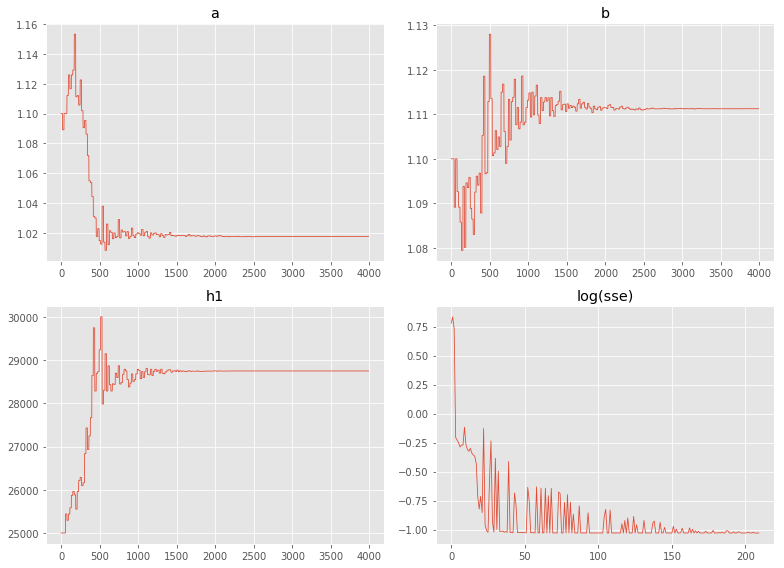

========T2 Simulation========
a* = -1.95646	b* = -1.49020            	h1* = 1.88971
a = 1.14136	b = 1.22533	h1 = 34389.92692
Success: True, Optimization terminated successfully.
Iterations: 110
SSE: 105.50364844435727


,Height,Suspended Mass
0,"4,375",1.41483e+10
1,"6,250",1.53796e+10
2,"8,125",1.60357e+10
3,"10,000",1.64249e+10
4,"11,875",1.66484e+10
5,"13,750",1.67516e+10
6,"15,625",1.67572e+10
7,"17,500",1.66762e+10
8,"19,375",1.65125e+10
9,"21,250",1.6264e+10


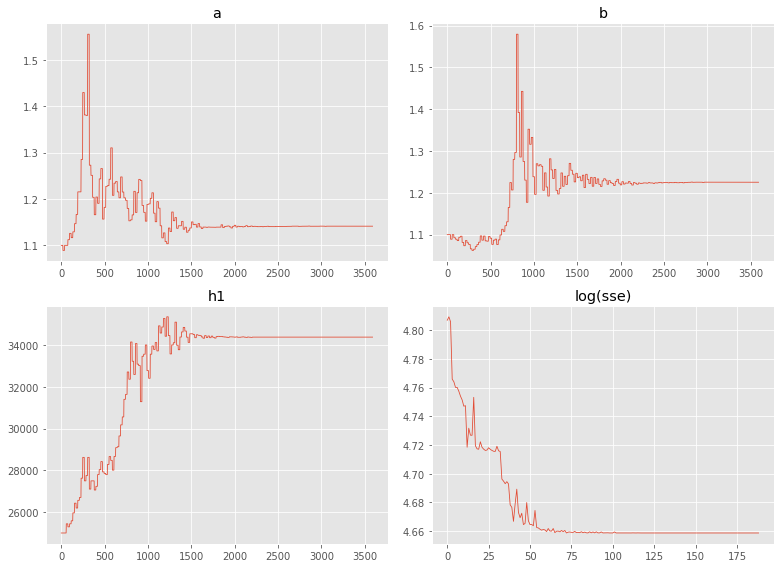

========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 13.98971	b* = 16.95571            	h1* = 5.30373
a = 1190292.62264	b = 23108528.49610	h1 = 39801.57390
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 558429339812.7583


,Height,Suspended Mass
0,"4,375",2.5e+11
1,"6,250",0
2,"8,125",0
3,"10,000",0
4,"11,875",0
5,"13,750",0
6,"15,625",0
7,"17,500",0
8,"19,375",0
9,"21,250",0


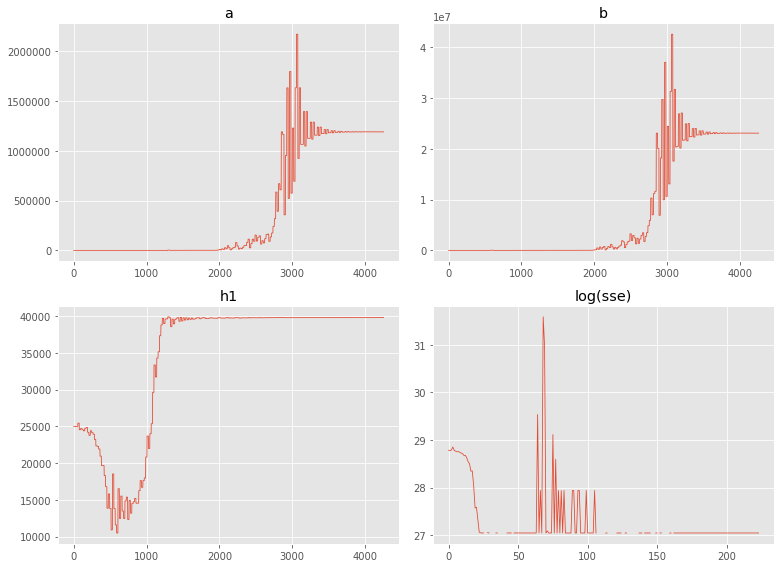

In [12]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 25000,
    "u": 1e-9,
    "v": 1e-9,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}

H = 40000

wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Forward Simulation", "T2 Simulation", "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_plume_inversion(
        df, len(df), 20, 
        config["VENT_ELEVATION"], H, 0,
        phi_steps, config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, params, sol, sse, trace, coef_matrices, sse_trace = out
    
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



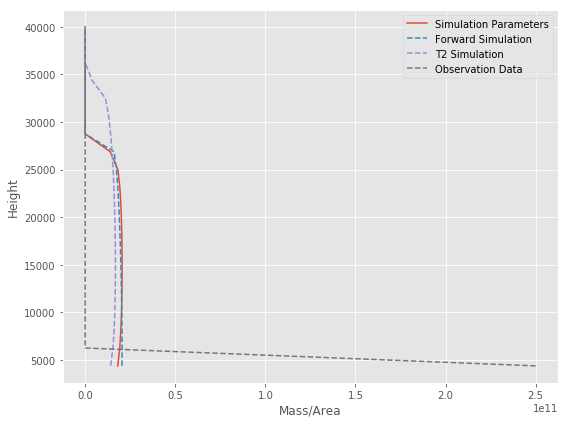

,Dataset,a,b,h1,u,v,D,ftt,M
0,Forward Simulation,1.01762,1.11125,"28,750",1e-09,1e-09,"92,066","3,600",2.5e+11
1,T2 Simulation,1.14136,1.22533,"34,389.9",1e-09,1e-09,"92,066","3,600",2.5e+11
2,Observation Data,1.19029e+06,2.31085e+07,"39,801.6",1e-09,1e-09,"92,066","3,600",2.5e+11


In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Forward Simulation========


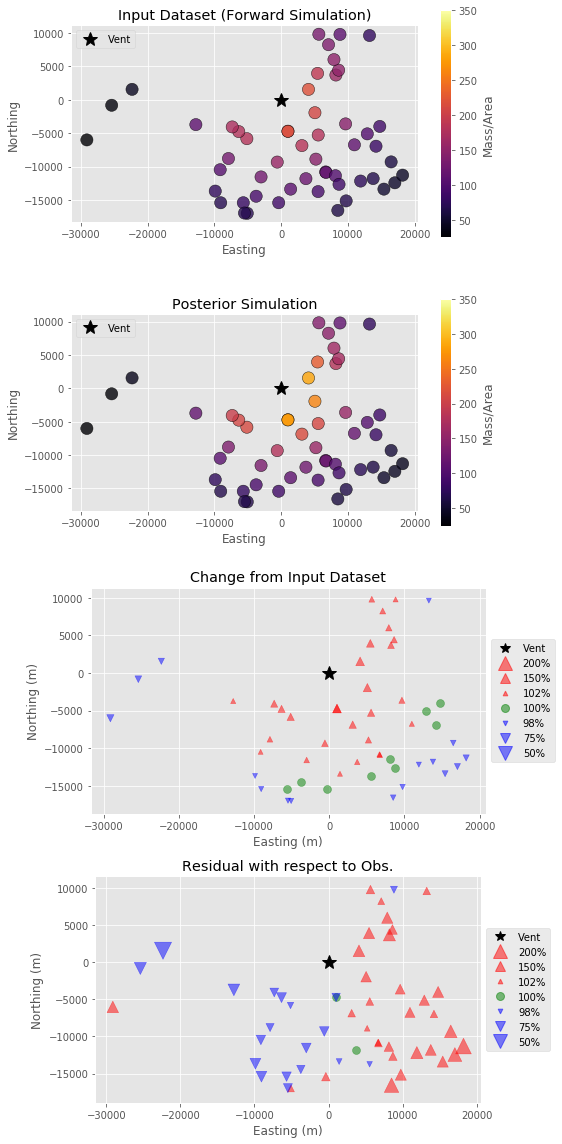

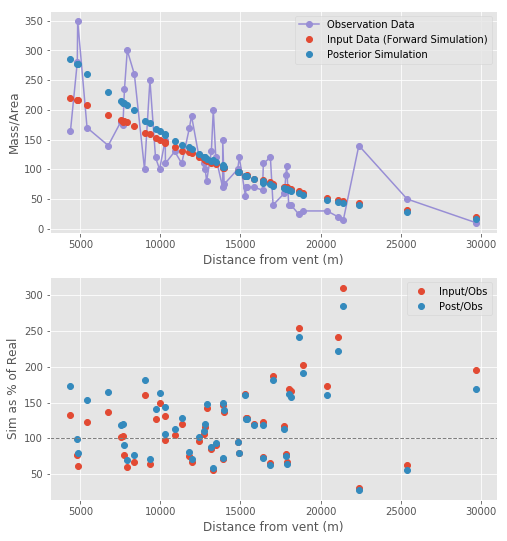

========T2 Simulation========


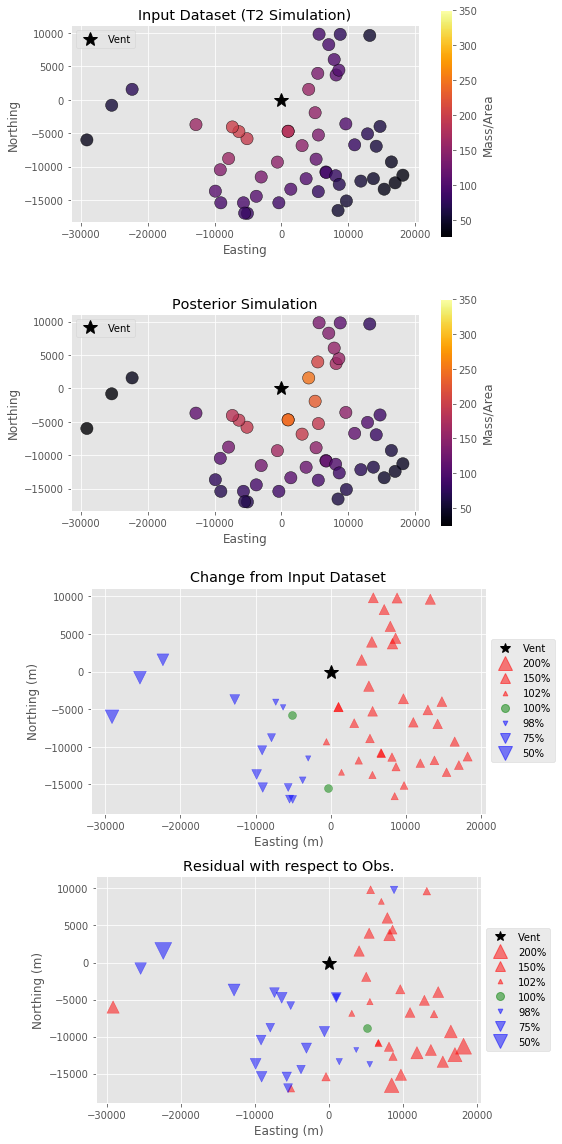

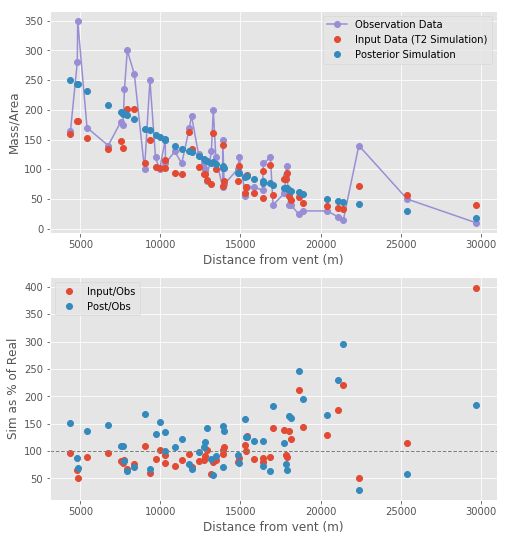

========Observation Data========


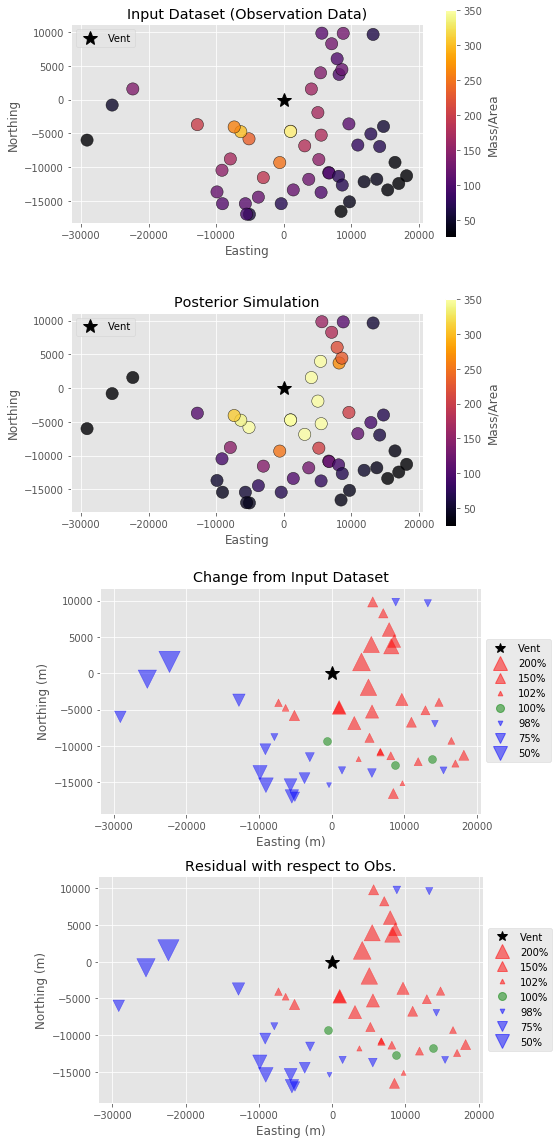

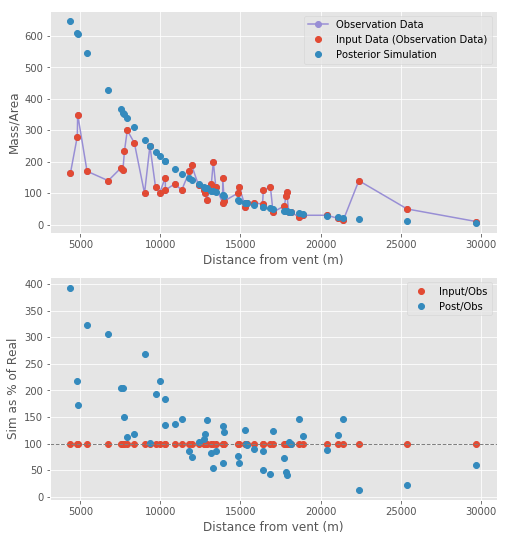

In [14]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(4,1, figsize=(
            8, 16), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds = (25, 350)
    vis.plot_sample(in_data, vent=(0,0), log=False,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="size",
                title="Change from Input Dataset", ax=axs[2])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual with respect to Obs.", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [15]:
# fig, axs = plt.subplots(2,1, figsize=(
#         8, 9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(obs_df["radius"].values, rotdf["MassArea"].values, 'C0-', label="Obs")
# axs[0].plot(df_merge["radius"].values, df_merge["MassArea"].values, 'C1-', label="Prior")
# axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C2-', label="Post")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3-', label="T2")
# axs[0].legend()
# axs[0].set_xlabel("Distance from vent (m)")
# axs[0].set_ylabel("Mass/Area")


# axs[1].plot(prior_res_obs["radius"].values, prior_res_obs["MassArea"].values, 'C1-', label="Prior/Obs")
# axs[1].plot(post_res_obs["radius"].values, post_res_obs["MassArea"].values, 'C2-', label="Post/Obs")
# axs[1].plot(t2_res_df["radius"].values, t2_res_df["MassArea"].values, 'C3-', label="T2/Obs")
# axs[1].legend()
# axs[1].set_xlabel("Distance from vent (m)")
# axs[1].set_ylabel("Residual (%)")
# plt.show()

========Forward Simulation========
a* = -2.30259	b* = -2.30259	            h1* = 0.74859	u* = 0.00307	v* = -0.11368	            D* = 11.73279	ftt* = 8.18869	TM* = 26.24473
a = 1.10000	b = 1.10000	            h1 = 28039.88627	u = 0.00307	v = -0.11368	            D = 124591.28001	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 242
SSE: 3.1778628344205395


,Height,Suspended Mass
0,"4,625",1.98579e+10
1,"6,750",2.10816e+10
2,"8,875",2.17243e+10
3,"11,000",2.20971e+10
4,"13,125",2.22968e+10
5,"15,250",2.23607e+10
6,"17,375",2.22992e+10
7,"19,500",2.21023e+10
8,"21,625",2.17333e+10
9,"23,750",2.10973e+10


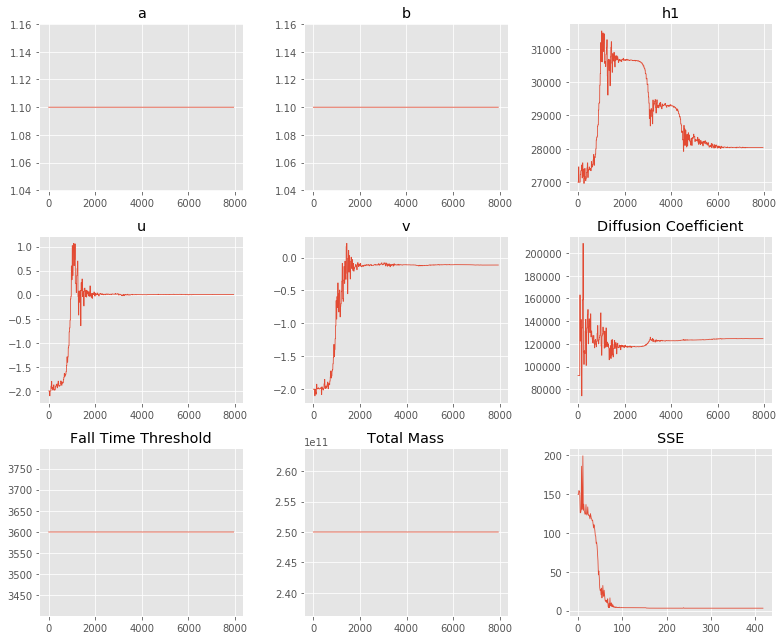

Forward Simulation Run Time: 2.08438 minutes


========T2 Simulation========
a* = -2.30259	b* = -2.30259	            h1* = 0.74558	u* = -2.29962	v* = -0.96010	            D* = 11.77867	ftt* = 8.18869	TM* = 26.24473
a = 1.10000	b = 1.10000	            h1 = 28000.00027	u = -2.29962	v = -0.96010	            D = 130440.42042	ftt = 3600.00000	TM = 249999999999.99973
Success: True, Optimization terminated successfully.
Iterations: 247
SSE: 4.438086208005491


,Height,Suspended Mass
0,"4,625",2.06375e+10
1,"6,750",2.19089e+10
2,"8,875",2.25764e+10
3,"11,000",2.29633e+10
4,"13,125",2.317e+10
5,"15,250",2.32353e+10
6,"17,375",2.317e+10
7,"19,500",2.29633e+10
8,"21,625",2.25764e+10
9,"23,750",2.19089e+10


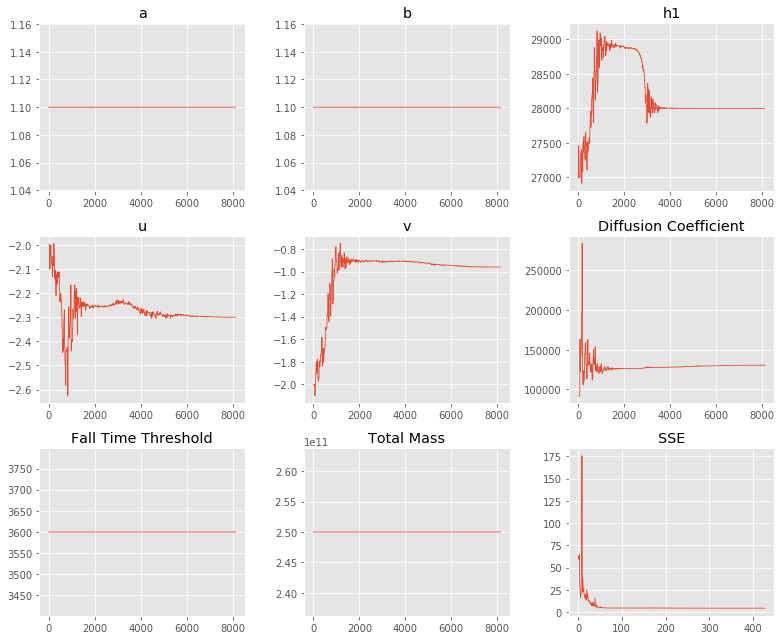

T2 Simulation Run Time: 2.13125 minutes


========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -2.30259	b* = -2.30259	            h1* = -0.82206	u* = -0.00139	v* = -0.00027	            D* = 12.55848	ftt* = 8.18869	TM* = 26.24473
a = 1.10000	b = 1.10000	            h1 = 4625.01963	u = -0.00139	v = -0.00027	            D = 284497.08064	ftt = 3600.00000	TM = 249999999999.99973
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 470
SSE: 92189539532.19588


,Height,Suspended Mass
0,"4,625",2.5e+11
1,"6,750",0
2,"8,875",0
3,"11,000",0
4,"13,125",0
5,"15,250",0
6,"17,375",0
7,"19,500",0
8,"21,625",0
9,"23,750",0


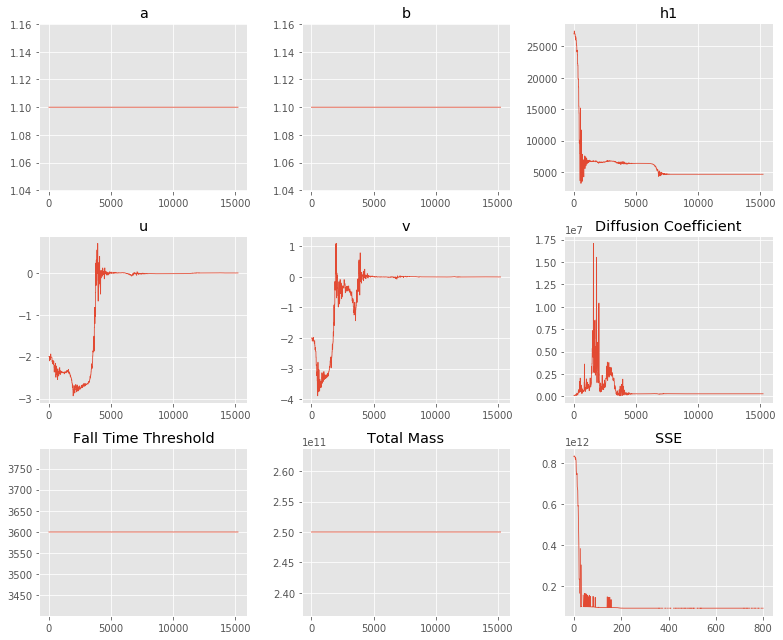

Observation Data Run Time: 3.96224 minutes


Total Run Time: 8.17786 minutes


In [44]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": config["PLUME_HEIGHT"],
    "u": -2,
    "v": -2,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : False,
    "b" : False,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": False,
    "M": False
}

H = 45000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Forward Simulation", 
         "T2 Simulation",
         "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-5]
    
    inv_mass, _, _, _ = beta_transform(*plume_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

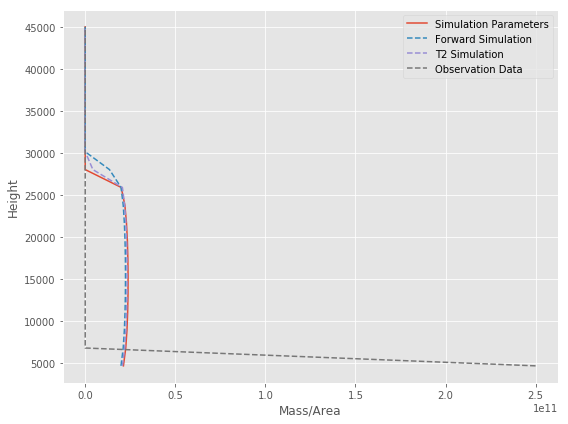

,Dataset,a,b,h1,u,v,D,ftt,M
0,Forward Simulation,1.1,1.1,"28,039.9",0.00307181,-0.113681,"124,591","3,600",2.5e+11
1,T2 Simulation,1.1,1.1,"28,000",-2.29962,-0.960097,"130,440","3,600",2.5e+11
2,Observation Data,1.1,1.1,"4,625.02",-0.00138912,-0.000273378,"284,497","3,600",2.5e+11


In [45]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Forward Simulation========


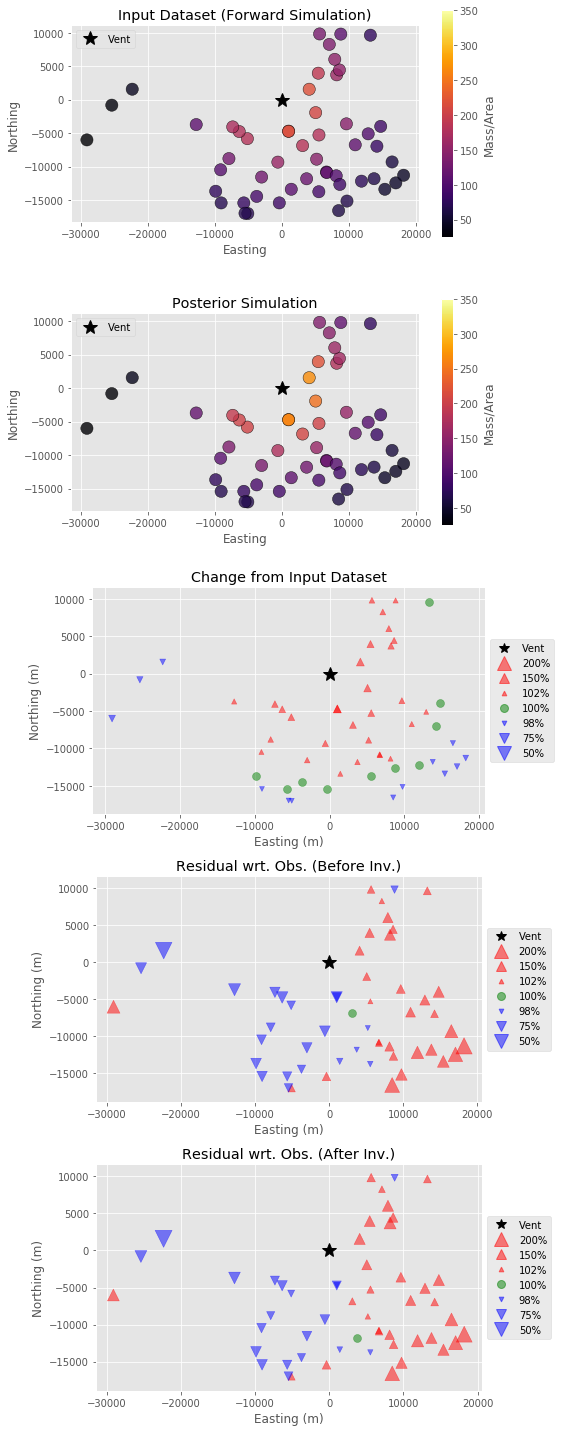

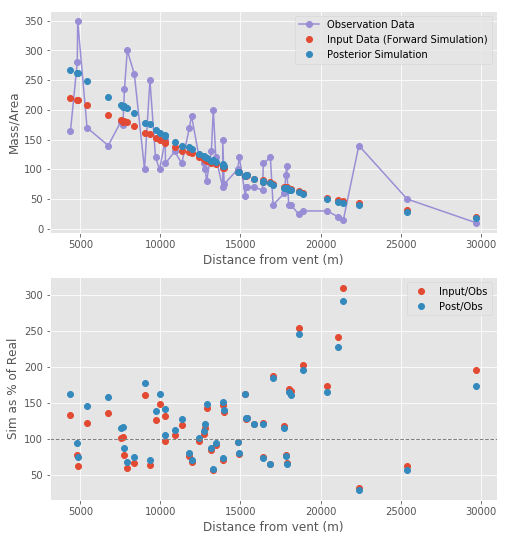

========T2 Simulation========


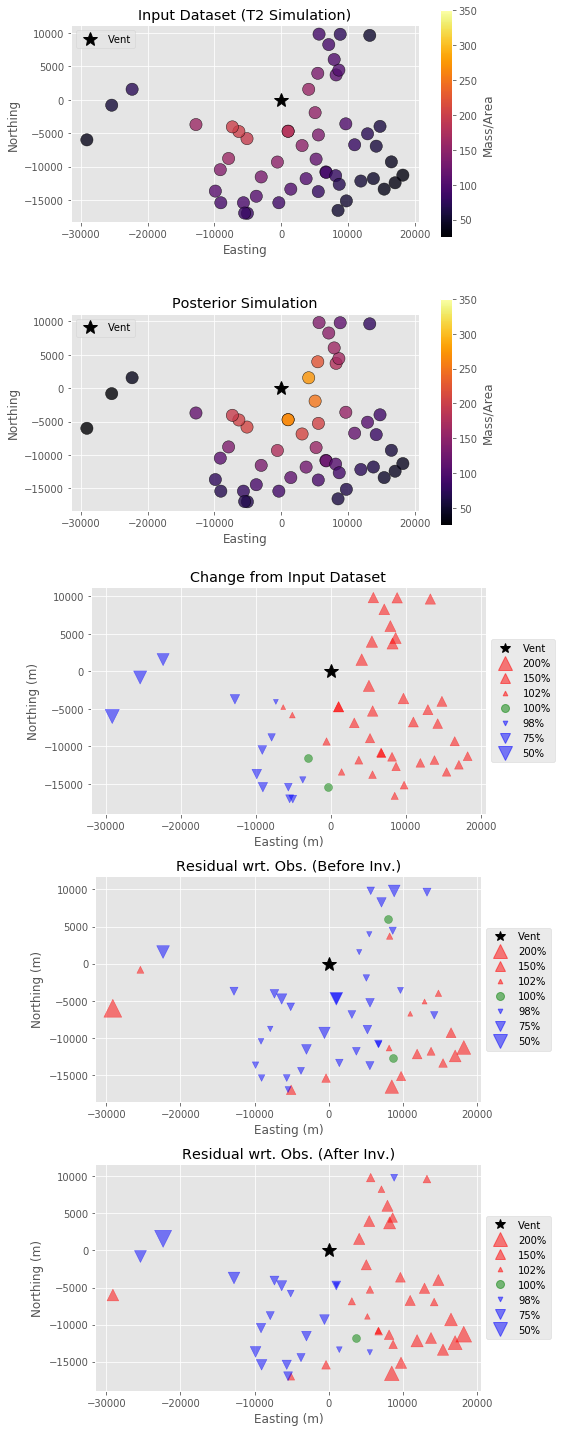

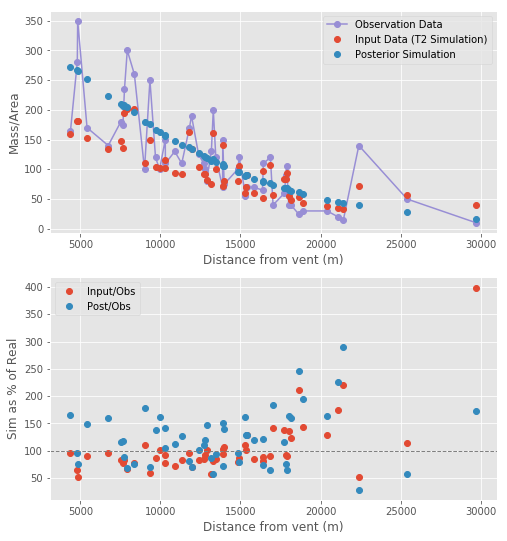

========Observation Data========


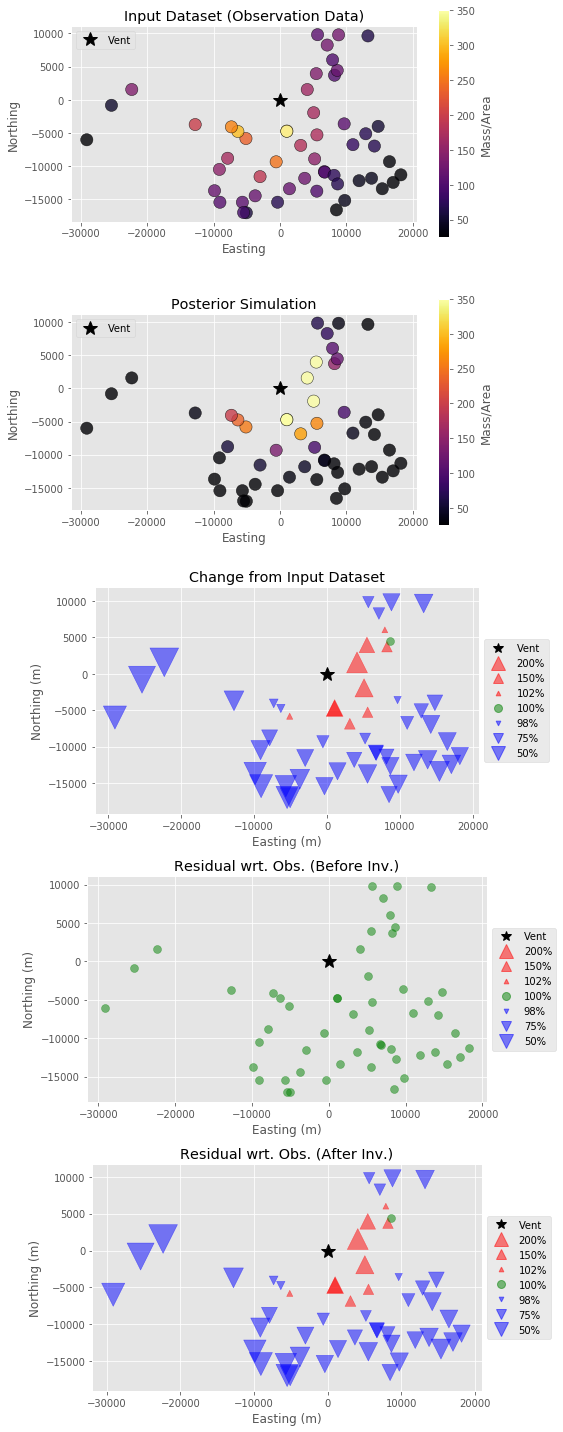

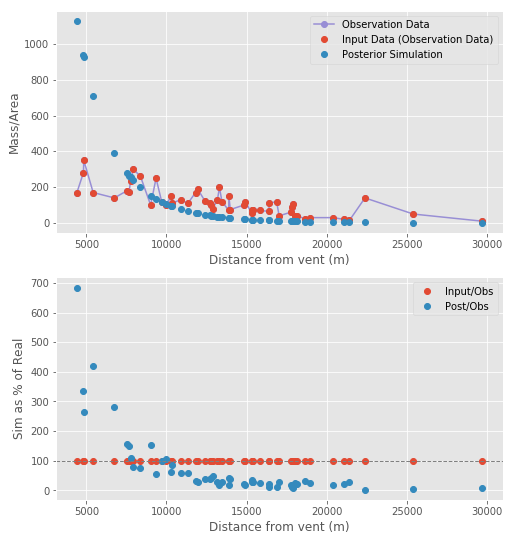

In [38]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(5,1, figsize=(
            8, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds = (25, 350)
    vis.plot_sample(in_data, vent=(0,0), log=False,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="size",
                title="Change from Input Dataset", ax=axs[2])
    vis.plot_residuals(in_data, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (Before Inv.)", ax=axs[3])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs. (After Inv.)", ax=axs[4])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

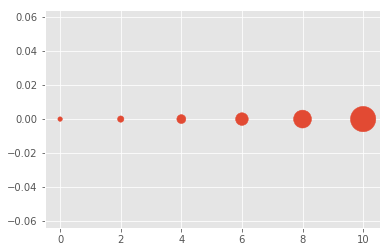

In [19]:
# doubling the area of markers
x = [0,2,4,6,8,10]
y = [0]*len(x)
s = [20*2**n for n in range(len(x))]
plt.scatter(x,y,s=s)
plt.show()

[170.5149978319906, 108.04562952784062, 22.16068689132129, 22.182402701225058, 82.46936830414997, 170.5149978319906]


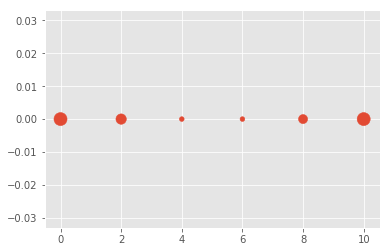

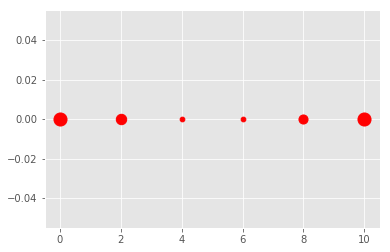

In [20]:
x = [0,2,4,6,8,10]
y = [0]*len(x)
z = [2.0, 1.5, 1.01, 1/.99, 1/.75, 1/.50]
s = [20+500*np.log10(n) for n in z]
print(s)
plt.scatter(x,y,s=s)
plt.show()

for ss, xx, yy in zip(s, x, y):
    plt.plot(xx, yy, "ro", ms=np.sqrt(ss))
plt.show()